# Part II - Part VI

In [1]:
import pandas as pd
import quandl

In [2]:
# get data
quandl.ApiConfig.api_key = 'oJmz56w2hhhifq8xs9sE'
df = quandl.get('WIKI/GOOGL')

# print head
print(df.head())

              Open    High     Low    Close      Volume  Ex-Dividend  \
Date                                                                   
2004-08-19  100.01  104.06   95.96  100.335  44659000.0          0.0   
2004-08-20  101.01  109.08  100.50  108.310  22834300.0          0.0   
2004-08-23  110.76  113.48  109.05  109.400  18256100.0          0.0   
2004-08-24  111.24  111.60  103.57  104.870  15247300.0          0.0   
2004-08-25  104.76  108.00  103.88  106.000   9188600.0          0.0   

            Split Ratio  Adj. Open  Adj. High   Adj. Low  Adj. Close  \
Date                                                                   
2004-08-19          1.0  50.159839  52.191109  48.128568   50.322842   
2004-08-20          1.0  50.661387  54.708881  50.405597   54.322689   
2004-08-23          1.0  55.551482  56.915693  54.693835   54.869377   
2004-08-24          1.0  55.792225  55.972783  51.945350   52.597363   
2004-08-25          1.0  52.542193  54.167209  52.100830   53.1

In [3]:
# pare dataframe
df = df[['Adj. Open', 'Adj. High', 'Adj. Low', 'Adj. Close', 'Adj. Volume']]

# add features
df['HL_PCT'] = (df['Adj. High'] - df['Adj. Close']) / df['Adj. Close'] * 100.0
df['PCT_change'] = (df['Adj. Close'] - df['Adj. Open']) / df['Adj. Open'] * 100.0

# further pare dataframe
df = df[['Adj. Close', 'HL_PCT', 'PCT_change', 'Adj. Volume']]

print(df.head())

            Adj. Close    HL_PCT  PCT_change  Adj. Volume
Date                                                     
2004-08-19   50.322842  3.712563    0.324968   44659000.0
2004-08-20   54.322689  0.710922    7.227007   22834300.0
2004-08-23   54.869377  3.729433   -1.227880   18256100.0
2004-08-24   52.597363  6.417469   -5.726357   15247300.0
2004-08-25   53.164113  1.886792    1.183658    9188600.0


In [4]:
# indicate forecast variable
forecast_col = 'Adj. Close'

# make all NaN outliers so we can work with them
df.fillna(-9999, inplace=True) 

# predict out to 1% of dataframe
import math
forecast_out = int(math.ceil(.01*len(df)))

df['label'] = df[forecast_col].shift(-forecast_out)
df.dropna(inplace=True)
print(df.tail())

            Adj. Close    HL_PCT  PCT_change  Adj. Volume    label
Date                                                              
2018-01-30     1177.37  0.896914   -0.029718    1792602.0  1094.00
2018-01-31     1182.22  0.346805   -0.134312    1643877.0  1053.15
2018-02-01     1181.59  0.495942    0.476195    2774967.0  1026.55
2018-02-02     1119.20  1.081129   -0.729098    5798880.0  1054.09
2018-02-05     1068.76  4.325574   -2.893850    3742469.0  1006.94


In [5]:
import numpy as np
from sklearn import preprocessing, model_selection, svm
from sklearn.linear_model import LinearRegression

# load features (X) and labels (y)
X = np.array(df.drop(['label'], 1))
y = np.array(df['label'])

X = preprocessing.scale(X)

X_lately = X[-forecast_out:]
X = X[:-forecast_out]
y = y[:-forecast_out]

df.dropna(inplace=True)

In [6]:
# split training and test set 80/20
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = .2)

# define classifier
clf = LinearRegression(n_jobs = -1)
clf.fit(X_train, y_train)

# dump to pickle file
import pickle
with open('data/linearregression.pickle', 'wb') as f:
    pickle.dump(clf, f)

# load pickle file
pickle_in = open('data/linearregression.pickle', 'rb')
clf = pickle.load(pickle_in)

accuracy = clf.score(X_test, y_test)

print("Accuracy", forecast_out, "days in advance:", accuracy)

Accuracy 35 days in advance: 0.9809807154216502


Text(0, 0.5, 'Price')

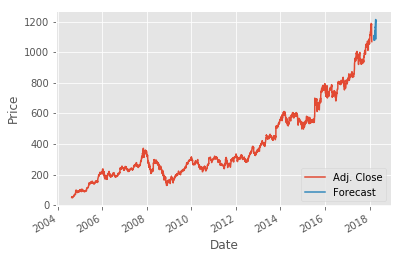

In [8]:
import datetime
import matplotlib.pyplot as plt
from matplotlib import style

# use plot style ggplot
style.use('ggplot')

# define forecast set
forecast_set = clf.predict(X_lately)

df['Forecast'] = np.nan

# plot by days
last_date = df.iloc[-1].name
last_unix = last_date.timestamp()
one_day = 86400 # number of seconds in a day
next_unix = last_unix + one_day

# update dates and forecast
for i in forecast_set:
    next_date = datetime.datetime.fromtimestamp(next_unix)
    next_unix += one_day
    df.loc[next_date] = [np.nan for _ in range(len(df.columns) - 1)] + [i]
    
df['Adj. Close'].plot()
df['Forecast'].plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')